## Sentiment Analysis using DistilBERT


### Dataset Prep


In [ ]:
%pip install symspellpy

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from symspellpy import SymSpell

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from PA notebook for text preprocessing

In [ ]:
import os.path
# Download and Load the SymSpell Dict

!wget -q https://github.com/mammothb/symspellpy/raw/master/symspellpy/frequency_dictionary_en_82_765.txt
# Initialize SymSpell

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = "/content/frequency_dictionary_en_82_765.txt"

# Check if dictionary path exists already, delete before creating
if os.path.exists(dictionary_path):
  !rm -f /content/frequency_dictionary_en_82_765.txt
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Returns cleaned text. Requires raw text (str) arg. Optional start (int), end (int) args.
def data_preprocessor(raw_text, start=None, end=None):

    # Clean text: Remove punctuations, all lowercase, strip(), remove any numbers
    cleaned_text = re.sub(r'[^\w\s]|\d+', '', str(raw_text).lower().strip())

    # Correct Spelling
    correction = sym_spell.lookup_compound(cleaned_text, max_edit_distance=2)
    corrected_text = correction[0].term if correction else cleaned_text # Extract only the corrected term.


    # Step 2: Tokenize text
    tokens = word_tokenize(corrected_text) #

    # Step 3: Remove stopwords (After spell correction)
    stop_words = set(stopwords.words('english'))

    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Step 4: Join all tokens into one string.
    final_text = ' '.join(filtered_tokens[start:end]) # Filter out unnecessary web info.

    return final_text

from PA notebook for lemmatization

In [ ]:
from nltk.corpus import stopwords # Already imported earlier but safer to reimport

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

lem = WordNetLemmatizer()

# Function to map POS tags to WordNet format
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('V'):
        return 'v'  # Verb
    elif treebank_tag.startswith('N'):
        return 'n'  # Noun
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'a'  # Adjective


# Function to lemmatize a tokenized dataset
def lemmatize_tokens(token_list):
    tagged_tokens = pos_tag(token_list)  # Apply POS tagging
    lemmatized_tokens = [
        lem.lemmatize(token, get_wordnet_pos(tag))
        for token, tag in tagged_tokens if token not in stop_words and len(token) > 1
    ]
    return ' '.join(lemmatized_tokens)  # Convert list back to a string

In [ ]:
# Import dataset
df = pd.read_csv('justice.csv')

# Drop rows with NA
df.dropna(inplace=True)
df.head()

# Create a backup of the dataset in case we need to go back to OG
df1 = df.copy()

# Drop irrelevant columns
df1.drop(columns=['Unnamed: 0', 'docket','name','first_party','second_party', 'issue_area',
                 'facts_len', 'majority_vote', 'minority_vote', 'href', 'ID','term'], inplace=True)

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment
5,5,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,majority opinion,reversed,First Amendment


Split dataset into target variable (y) `first_party_winner` and the independent variables (X) `decision_type`,  `disposition`, and `case facts`.

In [ ]:
df_cat = df1[['decision_type', 'disposition']]
df_target = df1[['first_party_winner']]
df_nlp = df1[['facts']]

# Reset indices to avoid NaNs during concatentation and One-Hot Encoding
df_cat.reset_index(drop=True, inplace=True)
df_target.reset_index(drop=True, inplace=True)
df_nlp.reset_index(drop=True, inplace=True)

> Apply One-Hot encoding on column with True or False.

In [ ]:
# One-Hot Encoding
label_encoder = LabelEncoder()
df_target = label_encoder.fit_transform(df_target)

# Change into Pandas Dataframe
df_target1 = pd.DataFrame(df_target, columns=['first_party_winner'])
df_target1.head()

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,first_party_winner
0,1
1,1
2,1
3,1
4,1


> Apply text preprocessing on facts column of table

In [ ]:
nltk.download('punkt_tab')

# Reassemble the dataframe with the one-hot encoded column
df_concat = pd.concat([df_cat, df_target1], axis=1, join='inner')
df_concat.head()

# Apply our text preprocessing on the facts column
df_nlp1 = pd.DataFrame(df_nlp, columns=['facts'])
df_nlp1['facts'] = df_nlp1['facts'].str.replace(r'<[^<>]*>', '', regex=True)

# Split into tokens and use our preprocessor function
df_nlp1['facts_clean'] = df_nlp1['facts'].apply(lambda x: data_preprocessor(str(x)))
df_nlp1.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,facts,facts_clean
0,Joan Stanley had three children with Peter Sta...,joan stanley three children peter stanley stan...
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified males must prefer...
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...


In [ ]:
# Reassemble the facts column with the first_party_winner column
df_nlp2 = pd.concat([df_nlp1, df_target1['first_party_winner']], axis=1, join='inner')
df_nlp2.head()

,facts,facts_clean,first_party_winner
0,Joan Stanley had three children with Peter Sta...,joan stanley three children peter stanley stan...,1
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,1
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified males must prefer...,1
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,1
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,1


##### Bigram Visualization

Bigram of facts column where `first_party_winner` was True

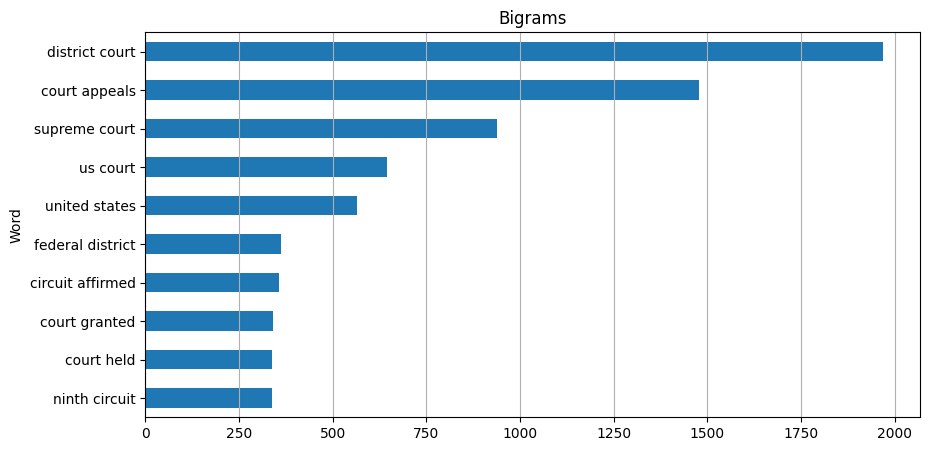

In [ ]:
from matplotlib.pyplot import figure

# From the rows where case won, store the cleaned facts
corpus = df_nlp2[df_nlp2['first_party_winner'] == 1]['facts_clean']

# Tokenize to create bigram graph
facts_tokens = word_tokenize(' '.join(corpus))

# Create a horizontal bar graph of the popular bigrams
word_freqs = nltk.FreqDist(nltk.ngrams(facts_tokens, 2))
dtf_bi = pd.DataFrame(word_freqs.most_common(), columns=['Word', 'Freq'])

# Get the possible words to place along y-axis
dtf_bi['Word'] = dtf_bi['Word'].apply(lambda x: ' '.join(string for string in x))
dtf_bi.set_index('Word').iloc[:10, :].sort_values(by="Freq").plot(
    kind='barh', title='Bigrams', legend=False, figsize=(10, 5)).grid(axis='x')

plt.show()

### Word Cloud

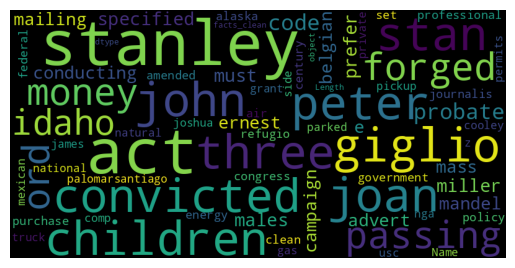

In [ ]:
import wordcloud

# Personalize Word Cloud
wc = wordcloud.WordCloud(background_color='black', max_words=100, max_font_size=100, width=800, height=400)
# Send Kaggle's corpus data to create word cloud, most freq is largest
wc = wc.generate(str(corpus))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc)
plt.show()

### Statistical Method Approach

> Used CountVectorizer to convert text into numerical form

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

# Create vectorizer to convert text --> numbers for model to understand
vectorizer = CountVectorizer()

X = df_nlp2['facts_clean']
y = df_nlp2['first_party_winner']

In [ ]:
# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

##### Decision Tree

In [ ]:
# Create pipe to train and score model perforamce on Decision Tree Classifier
pipe = Pipeline(steps=[('cv', CountVectorizer()), ('dt', DecisionTreeClassifier())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('dt', DecisionTreeClassifier())])

> Show Decision Tree scores on training and test set

In [ ]:
pipe.score(X_train, y_train)

1.0

In [ ]:
pipe.score(X_test, y_test)

0.5767741935483871

##### Random Forest

In [ ]:
# Create pipe to train and score model performance on RandomForest Classfier
pipe1 = Pipeline(steps=[('cv', CountVectorizer()), ('rf', RandomForestClassifier())])
pipe1.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('rf', RandomForestClassifier())])

> Show Random Forest scores on training and test set

In [ ]:
pipe1.score(X_train, y_train)

1.0

In [ ]:
pipe1.score(X_test, y_test)

0.6606451612903226

### k-fold Cross Validation

Creating 10 folds (repetitions) of training/testing: with a different part of data being train/test set in each fold

Taking average of all 10 accuracies from our model. Reduces the risk of getting lucky on a certain test set

> Standard deviation: how spread out the data is around the mean


In [ ]:
from sklearn.model_selection import cross_val_score

Decision Tree

> Accuracy increased ~0.3%

In [ ]:
accuracies = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10)
print('Decision Tree Results\n------------------------------------------')
print('Accuracy: {:.2f} %'.format(accuracies.mean()*100))
print('Standard Deviation: {:.2f} %'.format(accuracies.std()*100))
print('------------------------------------------')

Decision Tree Results
------------------------------------------
Accuracy: 54.84 %
Standard Deviation: 2.89 %
------------------------------------------


Random Forest

> Accuracy increased 0.02%

In [ ]:
accuracies1 = cross_val_score(estimator=pipe1, X=X_train, y=y_train, cv=10)
print('Random Forest Results\n------------------------------------------')
print('Accuracy: {:.2f} %'.format(accuracies1.mean()*100))
print('Standard Deviation: {:.2f} %'.format(accuracies1.std()*100))
print('------------------------------------------')

Random Forest Results
------------------------------------------
Accuracy: 66.08 %
Standard Deviation: 1.15 %
------------------------------------------


### Fine Tuning Custom Model

> Why DistilBERT?

DistilBERT is a smaller, faster and cheaper version of BERT. It has 40% smaller than BERT and runs 60% faster while preserving over 95% of BERT’s performance.

In [ ]:
%pip install datasets transformers scikit-learn evaluate

In [ ]:
# Load IMDB dataset
from datasets import load_dataset
imdb = load_dataset("imdb")

# Create smaller datasets since imdb dataset is wayyy too BIG
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

> Tokenize dataset using DistilBERT tokenizer

In [ ]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)

In [ ]:
from transformers import DataCollatorWithPadding, AutoModelForSequenceClassification

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [ ]:
import numpy as np
import evaluate

def compute_metrics(eval_pred):
   load_accuracy = evaluate.load("accuracy")
   load_f1 = evaluate.load("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)

   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

In [ ]:
from transformers import TrainingArguments, Trainer

# Finetuning on dataset size of 3300
training_args = TrainingArguments(
   output_dir="finetuning-sentiment-model-3000-samples",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
# Fine tune
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: elle-her2536 (elle-her2536-na) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


Step,Training Loss


TrainOutput(global_step=376, training_loss=0.29230671740592795, metrics={'train_runtime': 19568.021, 'train_samples_per_second': 0.307, 'train_steps_per_second': 0.019, 'total_flos': 782725021021056.0, 'train_loss': 0.29230671740592795, 'epoch': 2.0})

> Model scores on test dataset. Based on the compute metrics.

In [ ]:
# Evaluate model
trainer.evaluate()

{'eval_loss': 0.3332037329673767,
 'eval_model_preparation_time': 0.0029,
 'eval_accuracy': 0.86,
 'eval_f1': 0.8609271523178808,
 'eval_runtime': 272.1183,
 'eval_samples_per_second': 1.102,
 'eval_steps_per_second': 0.07}

> Uploaded the finetuned model to HuggingFace since it took ~7 hours to train

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
trainer.push_to_hub()

Further decreased train and test set size to see how it performs

In [ ]:
# Load IMDB dataset
from datasets import load_dataset
imdb = load_dataset("imdb")

# Create smaller datasets since imdb dataset is wayyy too BIG
smaller_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(500))])
smaller_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(50))])

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

# Tokenize dataset
tokenized_sm_train = smaller_train_dataset.map(preprocess_function, batched=True)
tokenized_sm_test = smaller_test_dataset.map(preprocess_function, batched=True)

In [ ]:
from transformers import DataCollatorWithPadding, AutoModelForSequenceClassification

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [ ]:
from transformers import TrainingArguments, Trainer

# Same training args
training_args = TrainingArguments(
   output_dir="finetuning-sentiment-model-500-samples",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
)

# Change the tokenzied train and test to smaller versions (500)
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_sm_train,
   eval_dataset=tokenized_sm_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

<ipython-input-9-245812a969a1>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Fine tune
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: elle-her2536 (elle-her2536-na) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


TrainOutput(global_step=64, training_loss=0.5916678309440613, metrics={'train_runtime': 63.4064, 'train_samples_per_second': 15.771, 'train_steps_per_second': 1.009, 'total_flos': 131345565373632.0, 'train_loss': 0.5916678309440613, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.48883646726608276,
 'eval_accuracy': 0.86,
 'eval_f1': 0.8627450980392157,
 'eval_runtime': 2.1988,
 'eval_samples_per_second': 22.74,
 'eval_steps_per_second': 1.819,
 'epoch': 2.0}

**Observations**:
*   Evalution accuracy did not change.
*   Evaluation F1 score increased slightly. This could be due to the reduction of test set size.



In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
trainer.push_to_hub()

### Predict with Kaggle Validation Dataset

Ground Truth Labels:
*   Negative or 0
*   Negative or 0
*   Positive or 1
*   Positive or 1

Validation on finetuned model (trained on dataset size 3000 rows)

In [ ]:
from transformers import pipeline

sentiment_model = pipeline("sentiment-analysis", model="RedShadow30/finetuning-sentiment-model-3000-samples")
results = sentiment_model(["joan stanley three children peter stanley stanleys never married lived together years joan died state illinois took children illinois law unwed fathers presumed unfit parents regardless actual fitness children became wards state peter appealed decision arguing illinois law violated equal protection clause fourteenth amendment unwed mothers deprived children without showing actually unfit parents illinois supreme court rejected stanleys equal protection claim holding actual fitness parent irrelevant childrens mother unmarried first party lost",
                 "miller conducting mass mailing campaign advertise sale adult material convicted violating california statute prohibiting distribution obscene material unwilling recipients millers brochures complained police initiating legal proceedings first party lost",
                 "ernest e mandel belgian professional charged with speeding ticket proved innocent proof for case was found through the highway traffic cams first party won",
                 "officer judy hopps and newly appointed junior officer nick wilde successfully captured mayor bellweather case solved"])

In [ ]:
results

[{'label': 'LABEL_0', 'score': 0.868590235710144},
 {'label': 'LABEL_0', 'score': 0.864529550075531},
 {'label': 'LABEL_0', 'score': 0.6159089207649231},
 {'label': 'LABEL_1', 'score': 0.6475655436515808}]

Validation on finetuned model with dataset size 500 rows for train and 50 for test

In [ ]:
from transformers import pipeline

sentiment_model_2 = pipeline("sentiment-analysis", model="RedShadow30/finetuning-sentiment-model-500-samples")
results_2 = sentiment_model_2(["joan stanley three children peter stanley stanleys never married lived together years joan died state illinois took children illinois law unwed fathers presumed unfit parents regardless actual fitness children became wards state peter appealed decision arguing illinois law violated equal protection clause fourteenth amendment unwed mothers deprived children without showing actually unfit parents illinois supreme court rejected stanleys equal protection claim holding actual fitness parent irrelevant childrens mother unmarried first party lost",
                 "miller conducting mass mailing campaign advertise sale adult material convicted violating california statute prohibiting distribution obscene material unwilling recipients millers brochures complained police initiating legal proceedings first party lost",
                 "ernest e mandel belgian professional charged with speeding ticket proved innocent proof for case was found through the highway traffic cams first party won",
                 "officer judy hopps and newly appointed junior officer nick wilde successfully captured mayor bellweather case solved"])

In [ ]:
results_2

[{'label': 'LABEL_0', 'score': 0.5308018922805786},
 {'label': 'LABEL_0', 'score': 0.5566582679748535},
 {'label': 'LABEL_0', 'score': 0.5304228067398071},
 {'label': 'LABEL_0', 'score': 0.5199348330497742}]

As expected the score value and accuracy of the label is dependent on the dataset size. As the dataset size decreased from 3300 rows to 550 rows, the accuracy of the sentiment and scores decrease. Therefore, we may conclude that there is a direct relationship between dataset size and prediction accuracy.

> Following Oziel's lead on seeing word distribution and feature importance for DistilBERT

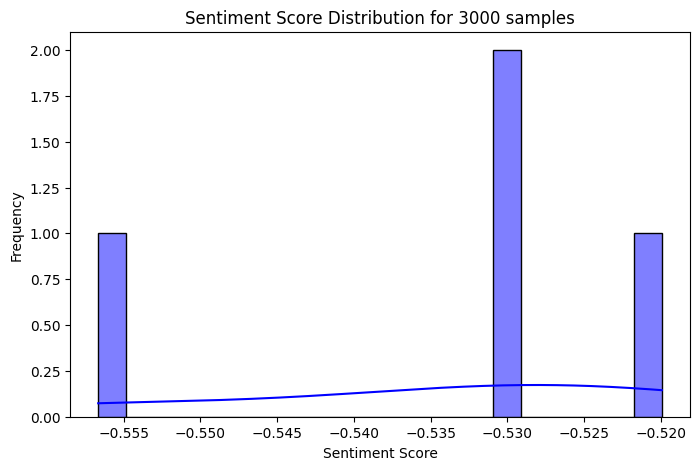

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords


# Extract sentiment scores from DistilBERT predictions
sentiment_scores = [res["score"] if res["label"] == "POSITIVE" else -res["score"] for res in results]

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(sentiment_scores, bins=20, kde=True, color='blue')
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Sentiment Score Distribution for 3000 samples")
plt.show()

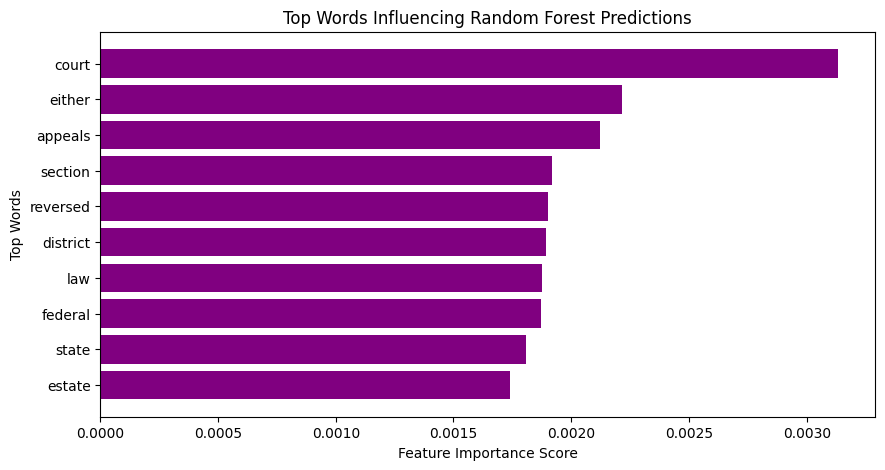

In [ ]:
feature_importances = pipe1.named_steps['rf'].feature_importances_
sorted_indices = np.argsort(feature_importances)[-10:]  # Get top 10 important features
cv = pipe1.named_steps['cv']
sorted_features = np.array(cv.get_feature_names_out())[sorted_indices]

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(sorted_features, feature_importances[sorted_indices], color='purple')
plt.xlabel("Feature Importance Score")
plt.ylabel("Top Words")
plt.title("Top Words Influencing Random Forest Predictions")
plt.show()

### Observations 🧐

> Most cases will be labelled as `Negative` since many words used in cases have negative connotations.

> Third case should be Positive since defendant won the case but still labels as `0 or Negative`.


### Using a Pretrained IMDB DistilBert

Dataset size >50000 rows



In [ ]:
from transformers import pipeline

pretrained_pipe = pipeline("text-classification", model="dhlee347/distilbert-imdb")

In [ ]:
results = pretrained_pipe(["joan stanley three children peter stanley stanleys never married lived together years joan died state illinois took children illinois law unwed fathers presumed unfit parents regardless actual fitness children became wards state peter appealed decision arguing illinois law violated equal protection clause fourteenth amendment unwed mothers deprived children without showing actually unfit parents illinois supreme court rejected stanleys equal protection claim holding actual fitness parent irrelevant childrens mother unmarried first party lost",
                 "miller conducting mass mailing campaign advertise sale adult material convicted violating california statute prohibiting distribution obscene material unwilling recipients millers brochures complained police initiating legal proceedings first party lost",
                 "ernest e mandel belgian professional charged with speeding ticket proved innocent proof for case was found through the highway traffic cams first party won",
                 "officer judy hopps and newly appointed junior officer nick wilde successfully captured mayor bellweather case solved"])

In [ ]:
results

[{'label': 'LABEL_0', 'score': 0.6666186451911926},
 {'label': 'LABEL_0', 'score': 0.8031566143035889},
 {'label': 'LABEL_1', 'score': 0.5488078594207764},
 {'label': 'LABEL_1', 'score': 0.7785549163818359}]

> Correctly predicts sentiment aka case outcome for validation set

### Predict on Cleaned Legal Dataset

In [ ]:
# Store a list of cleaned legal case texts
cleaned_legal = []

# Add 'party won' or 'party lost' at the end of text based on df_nlp2['first_party_winner']
for won_case in df_nlp2[df_nlp2['first_party_winner'] == 1]['facts_clean'].values.tolist():
  cleaned_legal.append(won_case + ' party won')

for lost_case in df_nlp2[df_nlp2['first_party_winner'] == 0]['facts_clean'].values.tolist():
  cleaned_legal.append(lost_case + ' party lost')

# Take 50 random cases
clean_50_legal = np.random.choice(cleaned_legal, 50)

In [ ]:
# Send list to pipeline
legal_clean_results = pretrained_pipe(clean_50_legal.tolist())

In [ ]:
legal_clean_results

[{'label': 'LABEL_1', 'score': 0.5017602443695068},
 {'label': 'LABEL_0', 'score': 0.6286044716835022},
 {'label': 'LABEL_1', 'score': 0.5079293847084045},
 {'label': 'LABEL_0', 'score': 0.6385435461997986},
 {'label': 'LABEL_0', 'score': 0.6912609934806824},
 {'label': 'LABEL_0', 'score': 0.5836912393569946},
 {'label': 'LABEL_0', 'score': 0.5136929154396057},
 {'label': 'LABEL_0', 'score': 0.5919673442840576},
 {'label': 'LABEL_0', 'score': 0.5274717807769775},
 {'label': 'LABEL_0', 'score': 0.6786718964576721},
 {'label': 'LABEL_1', 'score': 0.5092096924781799},
 {'label': 'LABEL_0', 'score': 0.6834483742713928},
 {'label': 'LABEL_0', 'score': 0.8133862614631653},
 {'label': 'LABEL_0', 'score': 0.6328545212745667},
 {'label': 'LABEL_0', 'score': 0.6915015578269958},
 {'label': 'LABEL_0', 'score': 0.5550652742385864},
 {'label': 'LABEL_0', 'score': 0.6823887825012207},
 {'label': 'LABEL_0', 'score': 0.648094654083252},
 {'label': 'LABEL_0', 'score': 0.6533318161964417},
 {'label': 'L

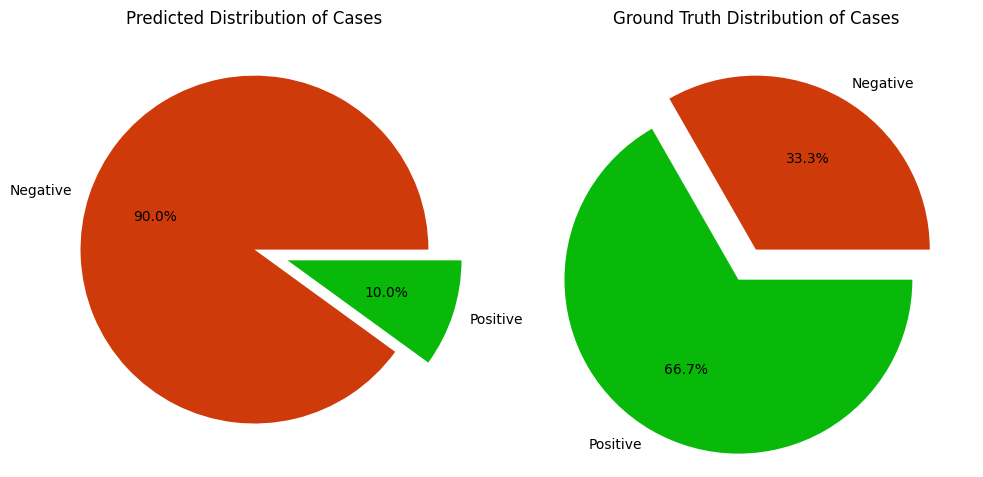

In [ ]:
# create pie chart of the label distribution
import matplotlib.pyplot as plt
import numpy as np

counts = [0, 0]
explode = [0, 0.2]
colors = ['#cf3a0a', '#08b90a']
labels = ['Negative', 'Positive']

# Count negative and positive from models predictions
for label in legal_clean_results:
  if label['label'] == 'LABEL_0':
    counts[0] += 1
  else:
    counts[1] += 1

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Show the predicted # of pos and neg cases
ax1.pie(counts, labels=labels, autopct='%1.1f%%', explode=explode, colors=colors)
ax1.set_title('Predicted Distribution of Cases')

# Show the true # of pos and neg cases from ground truth
ax2.pie([df_nlp2[df_nlp2['first_party_winner'] == 0].count().values[0], df_nlp2[df_nlp2['first_party_winner'] == 1].count().values[0]], labels=labels, autopct='%1.1f%%', explode=explode, colors=colors)
ax2.set_title('Ground Truth Distribution of Cases')

# Prevent overlap between charts
plt.tight_layout()

plt.show()

Observation:

*   Pretrained DistilBERT also struggles with case sentiment prediction even after finetuning on >50000 rows of IMDB dataset.
*   Negative words have a large impact on the predicted sentiment.



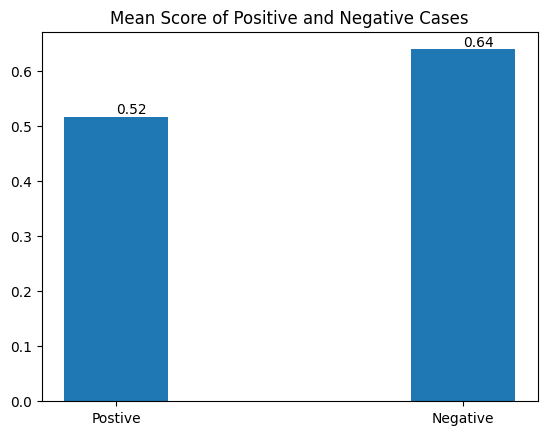

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statistics import mean

# Show score levels of positives and negatives
labels = ['Negative', 'Positive', 'Overall']

df = pd.DataFrame(legal_clean_results)

# Get mean score of both labels
pos_mean = mean(df[df['label'] == 'LABEL_1']['score'].values.tolist())
neg_mean = mean(df[df['label'] == 'LABEL_0']['score'].values.tolist())

plt.bar(['Postive', 'Negative'], [pos_mean, neg_mean], width=0.3)

# Display the mean scores
plt.text('Postive', pos_mean, f'{pos_mean:.2f}', va='bottom')
plt.text('Negative', neg_mean, f'{neg_mean:.2f}', va='bottom')

# Add title
plt.title('Mean Score of Positive and Negative Cases')
plt.show()